In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from interstellar import *
import warnings

warnings.filterwarnings('ignore')
wlsubjects = [114, 115, 127, 135, 136, 139, 141, 142]

# Set path to dataframe directory
df_dir = "../data/dataframes/"

roi_labels = ["V1", "V2", "V3", "V4", "V3ab", "IPS0", "LO1"]

## 1D Polar angle activation profiles

In [2]:
# Load fits
suffix = 'target-aligned_V1-LO1'

vm_fname = os.path.join(df_dir, "interstellar_vonmises_fits_%s.tsv" % suffix)
boot_name = os.path.join(df_dir, "parf_params_boots_%s.tsv" % suffix)
norm_name = os.path.join(df_dir, "interstellar_norm.tsv")

 
vm_fits = pd.read_csv(vm_fname, sep = '\t', index_col = 0)
boot_fits = pd.read_csv(boot_name, sep = '\t', index_col = 0)
interstellar_norm = pd.read_csv(norm_name, sep = '\t', index_col = 0)


In [3]:
group1 = [1.0, 2.0, 3.0]

evc = boot_fits.query("@group1 in roi")
lvc = boot_fits.query("@group1 not in roi")

def boot_compute(data, y_var, y_val, boot_colname, conds = [], method = 'subtract', groupby = [], 
                 plot = False):
    cond1 = conds[0]
    cond2 = conds[1]

    data = data.groupby(groupby + [boot_colname]).mean()

    cond1_values = data.query("%s == @cond1" % (y_var))[y_val].values
    cond2_values = data.query("%s == @cond2" % (y_var))[y_val].values

    if method == 'subtract':
        vals = cond1_values - cond2_values
    elif method == 'ratio':
        vals = cond1_values / cond2_values

    if plot:
        plt.hist(vals, bins = 30)

    return vals


def regression(data, x_var, y_var):
    y = data[y_var].values
    x = data[x_var].values
    y_ = y.mean()
    x_ = x.mean()

    Y = y - y_
    X = x - x_

    m = (Y.T @ X) / (X.T @ X)
    b = y_ - m*x_

    y_hat = m*x + b
    r_sq = 1 - np.sum(np.square(y_hat - y)) / np.sum(np.square(y - y_))

    return m, b, r_sq


### Recode groups

In [39]:
boot_fits['roi_label'] = [roi_labels[int(roi-1)] for roi in boot_fits.roi.values]
roi_codes = {'V1': 1,
              'V2': 2,
              'V3': 3,
              'V4': 4,
              'LO1': 4,
              'V3ab': 4,
              'IPS0': 5}
boot_fits['roi_codes'] = [roi_codes[roi_label] for roi_label in boot_fits.roi_label.values]

In [40]:
groups = boot_fits.groupby(['task', 'n_boot'])
rows = []
for key, group in groups:
    m, b, rsq = regression(group, 'roi_codes', 'fwhm')
    rows.append([*key, m, b, rsq])

boot_slopes = pd.DataFrame(data = rows, columns=['task', 'n_boot', 'slope', 'intercept', 'r2'])

for task, group in boot_slopes.groupby("task"):
    slope_mean = group.slope.mean()
    CI = (np.quantile(group.slope.values, [0.025, 0.975]))
    
    if task!='perception':
        print(task, '\t\t%0.01f' % slope_mean, '\t[%0.01f, %0.01f]' % (CI[0], CI[1]))
    else:
        print(task, '\t%0.01f' % slope_mean, '\t[%0.01f, %0.01f]' % (CI[0], CI[1]))



ltm 		13.2 	[4.1, 18.7]
perception 	20.9 	[17.9, 23.9]
wm 		14.0 	[10.1, 16.9]


In [41]:
task_groups = {'perception': 'perception',
              'ltm': 'memory',
              'wm': 'memory'}
roi_groups = {'V1': 'V1-V3',
              'V2': 'V1-V3',
              'V3': 'V1-V3',
              'V4': 'V4-IPS0',
              'LO1': 'V4-IPS0',
              'V3ab': 'V4-IPS0',
              'IPS0': 'V4-IPS0'}

boot_fits['task_group'] = [task_groups[str(task)] for task in boot_fits.task.values]
boot_fits['roi_group'] = [roi_groups[str(roi)] for roi in boot_fits.roi_label.values]

In [45]:
groups = boot_fits.groupby(['task_group', 'n_boot'])
rows = []
for key, group in groups:
    group = group.groupby(['roi_label', 'roi_group', 'task_group'], as_index=False).mean()
    
    m, b, rsq = regression(group, 'roi_codes', 'fwhm')
    rows.append([*key, m, b, rsq])

boot_slopes = pd.DataFrame(data = rows, columns=['task_group', 'n_boot', 'slope', 'intercept', 'r2'])

for task, group in boot_slopes.groupby("task_group"):
    slope_mean = group.slope.mean()
    CI = (np.quantile(group.slope.values, [0.025, 0.975]))
    
    if task!='perception':
        print(task, '\t\t%0.01f' % slope_mean, '\t[%0.01f, %0.01f]' % (CI[0], CI[1]))
    else:
        print(task, '\t%0.01f' % slope_mean, '\t[%0.01f, %0.01f]' % (CI[0], CI[1]))

memory 		13.6 	[8.3, 17.1]
perception 	20.9 	[17.9, 23.9]


diff = 7.3, CI [3.9, 13.5]


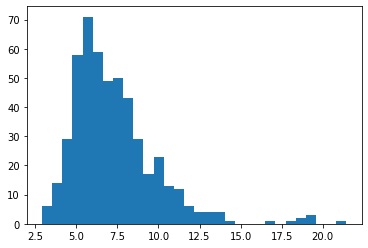

In [54]:
vals = boot_compute(boot_slopes, "task_group", "slope", conds = ['perception', 'memory'], boot_colname = 'n_boot',
                    method = 'subtract', groupby = ['task_group'], plot = True)

slope_mean_diff = vals.mean()
slope_CI_diff = (np.quantile(vals, [0.025, 0.975]))

print("diff = %0.01f, CI [%0.01f, %0.01f]" % (slope_mean_diff, slope_CI_diff[0], slope_CI_diff[1]))

In [69]:
for i, group in boot_fits.groupby("roi_group"):
    vals = boot_compute(group, "task_group", "fwhm", conds = ["memory", "perception"], boot_colname = 'n_boot', 
                        method = 'subtract', groupby=['task_group'], plot=False)
        
    CI = np.quantile(vals, [0.025, 0.975])
    mu = vals.mean()
    if i=='V1-V3':
        print(i, '\t\t%0.01f' % mu, '\t[%0.01f, %0.01f]' % (CI[0], CI[1]))
    else:
        print(i, '\t%0.01f' % mu, '\t[%0.01f, %0.01f]' % (CI[0], CI[1]))

V1-V3 		19.0 	[13.1, 28.0]
V4-IPS0 	2.8 	[-3.6, 8.3]


In [58]:
for key, group in boot_fits.groupby(['roi_label']):
    
    vals = boot_compute(group, "task_group", "fwhm", conds = ["memory", "perception"], boot_colname = 'n_boot', 
                     method = 'subtract', groupby=['task_group'])
    
    CI = np.quantile(vals, [0.025, 0.975])
    mu = vals.mean()

    print(key, '%0.02f' % mu, '[%0.02f, %0.02f]' % (CI[0], CI[1]))
    

IPS0 3.35 [-19.23, 22.63]
LO1 -6.86 [-24.29, 5.70]
V1 30.70 [14.22, 59.35]
V2 16.85 [10.03, 22.90]
V3 9.56 [4.45, 14.88]
V3ab 15.67 [9.12, 23.75]
V4 -1.07 [-10.00, 8.65]


# 2D polar angle activation profiles

In [72]:
B_norm = pd.read_csv(os.path.join(df_dir, "boot_norm.tsv"), sep = '\t', index_col=0)

roi_groups = {'V1': 'V1-V3',
              'V2': 'V1-V3',
              'V3': 'V1-V3',
              'V4': 'V4-IPS0',
              'LO1': 'V4-IPS0',
              'V3ab': 'V4-IPS0',
              'IPS0': 'V4-IPS0'}

B_norm['roi_group'] = [roi_groups[str(roi)] for roi in B_norm.roi.values]


In [75]:
tasks = ['perception', 'ltm']


data = B_norm.query("@tasks in task")
valid_boot_ids = np.arange(500)

for key, data in B_norm.groupby(['roi_group']):
    valid_boot_ids = np.arange(500)
    for _, group in data.groupby(['task']):
        valid_boot_ids = np.intersect1d(valid_boot_ids, group.n_boot.unique())
    
    data = data.query("@valid_boot_ids in n_boot")

    vals = boot_compute(data = data,
             y_var = 'task', y_val = 'x0', boot_colname= 'n_boot', 
             conds = ['ltm', 'perception'],
             method = 'subtract', groupby = ['task', 'roi_group'], plot = False)

    CI = np.quantile(vals, [0.025, 0.975])
    mu = vals.mean()
    p = (vals <= 0).mean()

    print(key, '%0.02f' % mu, '[%0.02f, %0.02f]' % (CI[0], CI[1]))

    

V1-V3 0.60 [-1.20, 3.33]
V4-IPS0 1.55 [-1.17, 8.41]


# Saccade splits

In [183]:
p_fname = "interstellar_tertile-sacc_params.tsv"
p_fname = os.path.join(df_dir, p_fname)
b_fname = "interstellar_tertile-sacc_boot_params.tsv"
b_fname = os.path.join(df_dir, b_fname)

P = pd.read_csv(p_fname, sep = '\t', index_col = 0)
B = pd.read_csv(b_fname, sep = '\t', index_col = 0)

In [198]:
B_allrois = B.groupby(['task', 'tertile', 'n_boot']).mean()

for key, group in B_allrois.groupby(['task']):
    vals = boot_compute(data = group,
                y_var = 'tertile', y_val = 'loc_deg', boot_colname= 'n_boot', 
                conds = ['clock', 'counter'],
                method = 'subtract', groupby = ['tertile'], plot = False)

    CI = np.quantile(vals, [0.025, 0.975])
    mu = vals.mean()
    p = (vals >= 0).mean()

    print(key, '%0.02f' % mu, '[%0.02f, %0.02f]' % (CI[0], CI[1]), p)


ltm -19.48 [-29.79, -8.21] 0.012
perception -2.07 [-4.69, 0.50] 0.056
wm -0.35 [-8.76, 10.33] 0.448


In [201]:
for key, group in B.groupby(['task', 'roi_labels']):
    vals = boot_compute(data = group,
                y_var = 'tertile', y_val = 'loc_deg', boot_colname= 'n_boot', 
                conds = ['clock', 'counter'],
                method = 'subtract', groupby = ['tertile', 'roi_labels'], plot = False)

    CI = np.quantile(vals, [0.025, 0.975])
    mu = vals.mean()
    p = (vals >= 0).mean()

    print(key, '%0.02f' % mu, '[%0.02f, %0.02f]' % (CI[0], CI[1]), p)

('ltm', 'IPS0') -43.31 [-61.06, -7.97] 0.008
('ltm', 'LO1') -11.79 [-50.38, 11.02] 0.208
('ltm', 'V1') -18.81 [-66.53, 54.33] 0.134
('ltm', 'V2') -5.39 [-17.99, 8.42] 0.212
('ltm', 'V3') -18.09 [-27.72, -3.98] 0.01
('ltm', 'V3ab') -10.93 [-26.30, 2.54] 0.056
('ltm', 'V4') -28.06 [-64.88, -0.97] 0.024
('perception', 'IPS0') 3.66 [-11.71, 20.35] 0.64
('perception', 'LO1') -3.11 [-15.19, 15.05] 0.316
('perception', 'V1') -6.01 [-10.01, -1.52] 0.004
('perception', 'V2') 1.05 [-2.31, 3.73] 0.768
('perception', 'V3') -3.55 [-6.18, -0.79] 0.0
('perception', 'V3ab') -6.31 [-10.75, -2.45] 0.0
('perception', 'V4') -0.21 [-5.27, 4.98] 0.474
('wm', 'IPS0') 6.70 [-7.77, 25.41] 0.798
('wm', 'LO1') 12.05 [-12.08, 49.78] 0.74
('wm', 'V1') -10.65 [-20.28, 0.39] 0.032
('wm', 'V2') 2.49 [-6.62, 13.43] 0.674
('wm', 'V3') 3.85 [-8.44, 16.46] 0.72
('wm', 'V3ab') -1.12 [-14.21, 12.39] 0.43
('wm', 'V4') -15.79 [-34.62, 6.54] 0.076


# Near vs. Far spaced targets

In [229]:
group = 'nearest_dist_bin'
keys = ['near', 'far']
tasks = ['perception', 'wm', 'ltm']

P, B = [], []

for key in keys:
    params_fname = "interstellar_%s-all_%s_params.tsv" % (group, key)
    boots_fname = "interstellar_%s-all_%s_boot_params.tsv" % (group, key)

    p = pd.read_csv(os.path.join(df_dir, params_fname), sep = "\t", index_col = 0)
    b = pd.read_csv(os.path.join(df_dir, boots_fname), sep = "\t", index_col = 0)
    p[group] = key
    b[group] = key
    
    P.append(p)
    B.append(b)

P = pd.concat(P)
B = pd.concat(B)

B['roi_labels'] = [roi_labels[int(l-1)] for l in B.roi.values]
P['roi_labels'] = [roi_labels[int(l-1)] for l in P.roi.values]

In [230]:
B_allrois

roi       loc   loc_deg    kappa1      scale1  \
task nearest_dist_bin n_boot                                                  
ltm  far              0       2.5 -0.160246 -9.181432  1.918971   35.425690   
                      1       2.5 -0.014607 -0.836926  2.570370   32.818050   
                      2       2.5  0.019399  1.111478  1.393733   67.859431   
                      3       2.5 -0.163360 -9.359845  2.291876  607.230897   
                      4       2.5 -0.114273 -6.547346  1.155181  526.601817   
...                           ...       ...       ...       ...         ...   
wm   near             495     2.5 -0.019857 -1.137697  3.096771   88.046656   
                      496     2.5 -0.084070 -4.816860  5.360340   96.129077   
                      497     2.5 -0.079508 -4.555462  1.065175  109.020967   
                      498     2.5 -0.003521 -0.201748  1.621549  129.556285   
                      499     2.5 -0.093340 -5.347973  2.050749  113.451597   

                                kappa2      scale2      maxr      minr  \
task nearest_dist_bin n_boot                                             
ltm  far              0       0.672582   35.435571  0.247233 -0.104551   
                      1       0.301443   34.567637  0.041093 -0.401777   
                      2       0.730054   69.108306  0.071126 -0.300716   
                      3       0.509223  607.709055  0.170449 -0.165828   
                      4       0.397890  527.510916  0.035636 -0.223428   
...                                ...         ...       ...       ...   
wm   near             495     1.205055   89.047171  0.061943 -0.253533   
                      496     0.804456   97.033886  0.167921 -0.247637   
                      497     0.906330  111.627994 -0.165228 -0.538249   
                      498     1.002233  131.489280 -0.085543 -0.422962   
                      499     0.731392  115.374157 -0.044661 -0.410224   

                                   amp        fwhm  
task nearest_dist_bin n_boot                        
ltm  far              0       0.351784  104.507853  
                      1       0.442870   87.080555  
                      2       0.371842   84.295431  
                      3       0.336278  100.427271  
                      4       0.259064  110.215111  
...                                ...         ...  
wm   near             495     0.315476   63.509991  
                      496     0.415558   73.079062  
                      497     0.373020   77.623671  
                      498     0.337419   70.057178  
                      499     0.365563   73.744199  

[3000 rows x 11 columns]

In [231]:
B_allrois = B.query("['V1', 'V2', 'V3', 'V4'] in roi_labels").groupby(['task', 'nearest_dist_bin', 'n_boot']).mean()

for key, group in B_allrois.groupby(['task']):
    vals = boot_compute(data = group,
                y_var = 'nearest_dist_bin', y_val = 'fwhm', boot_colname= 'n_boot', 
                conds = ['near', 'far'],
                method = 'ratio', groupby = ['nearest_dist_bin'], plot = False)

    CI = np.quantile(vals, [0.025, 0.975])
    mu = vals.mean()
    p = (vals >= 1).mean()

    print(key, '%0.02f' % mu, '[%0.02f, %0.02f]' % (CI[0], CI[1]), p)


ltm 0.68 [0.47, 0.97] 0.016
perception 0.93 [0.82, 1.07] 0.15
wm 1.06 [0.74, 1.71] 0.556


In [232]:
for key, group in B.groupby(['task', 'roi_labels']):
    vals = boot_compute(data = group,
                y_var = 'nearest_dist_bin', y_val = 'fwhm', boot_colname= 'n_boot', 
                conds = ['far', 'near'],
                method = 'ratio', groupby = ['nearest_dist_bin', 'roi_labels'], plot = False)

    CI = np.quantile(vals, [0.025, 0.975])
    mu = vals.mean()
    p = (vals <= 1).mean()

    print(key, '%0.02f' % mu, '[%0.02f, %0.02f]' % (CI[0], CI[1]), p)

('ltm', 'IPS0') 1.20 [0.78, 1.82] 0.204
('ltm', 'LO1') 0.96 [0.54, 1.82] 0.66
('ltm', 'V1') 1.81 [0.46, 4.27] 0.212
('ltm', 'V2') 1.94 [1.14, 3.45] 0.002
('ltm', 'V3') 1.35 [0.81, 1.93] 0.068
('ltm', 'V3ab') 1.01 [0.66, 1.46] 0.51
('ltm', 'V4') 1.40 [0.59, 2.62] 0.21
('perception', 'IPS0') 1.39 [0.96, 1.85] 0.054
('perception', 'LO1') 0.99 [0.72, 1.43] 0.562
('perception', 'V1') 1.16 [0.90, 1.44] 0.114
('perception', 'V2') 0.90 [0.71, 1.14] 0.836
('perception', 'V3') 1.14 [0.94, 1.39] 0.122
('perception', 'V3ab') 0.92 [0.82, 1.02] 0.93
('perception', 'V4') 1.12 [0.85, 1.39] 0.174
('wm', 'IPS0') 0.69 [0.38, 1.12] 0.936
('wm', 'LO1') 1.78 [0.59, 5.84] 0.1
('wm', 'V1') 1.29 [0.28, 3.79] 0.362
('wm', 'V2') 0.70 [0.45, 0.97] 0.988
('wm', 'V3') 1.02 [0.82, 1.42] 0.54
('wm', 'V3ab') 0.74 [0.51, 0.95] 0.986
('wm', 'V4') 1.17 [0.84, 1.80] 0.23
